1. To run ARIMA model we must first ensure our time series data is stationary
2. To do this we will run a apply the augmented Dicky-Fuller stationarity test with the diffretiation of the time series y
3. To use the ARIMA model we have to tune our model using auto_arima
4. We have to specify our p, q and max differentiation

In [1]:
##import library
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima
import numpy as np


# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (16,10)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
##import the temp train data
temp_train = pd.read_csv('temp_train.csv', parse_dates=True, index_col=0)
#temp_train
temp_train.head()

,temp_c
date,
1970-01-01,-12.8
1970-01-02,-4.9
1970-01-03,-1.4
1970-01-04,-4.4
1970-01-05,-3.0


To remove trend from ouur time series data we use the augmented Dicky_Fuller Stationary test

In [3]:
## apply the augmented Dicky-Fuller stationarity test

# recap: The null hypothesis is that the time series is NOT-stationary
# i.e. a small p value, less than 0.05, means that you have a stationary series

def print_adf(data):
    """ 
    Prints the results of the augmented Dickey Fuller Test
    """
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f""" 
              adf_stats: {adf_stats}
              p: {p} 
              used lag: {used_lag} 
              number of observations: {n_obs}
            
              CI 99%: {levels['1%']}
              CI 95%: {levels['5%']}
              CI 90%: {levels['10%']}
              information criterion (AIC): {information_criterion}
            """)

In [4]:
###create a diffrentiation of the time swries data
temp_train['diff1'] = temp_train['temp_c'].diff()
temp_train.head()

,temp_c,diff1
date,,
1970-01-01,-12.8,NaN
1970-01-02,-4.9,7.9
1970-01-03,-1.4,3.5
1970-01-04,-4.4,-3.0
1970-01-05,-3.0,1.4


In [5]:
print_adf(temp_train['diff1'].dropna())  ###dropna to remove na value

 
              adf_stats: -38.738248105844896
              p: 0.0 
              used lag: 20 
              number of observations: 18240
            
              CI 99%: -3.4307085647217015
              CI 95%: -2.8616984721626944
              CI 90%: -2.5668543505483656
              information criterion (AIC): 81599.45710008798
            


A p value of less than 0.5 means our temp data is station at a differentiation of 1 

In [6]:
#plot the auto corelation of the time series y to get range of your 'q'
##you will need reminder from trend seasonal to plot in your autocorrelaion and partial corelation map
### import the reminder from trend-seasonal linear regression

remainder = pd.read_csv('temp_remainder.csv', parse_dates=True, index_col=0)
#temp_train
remainder.head()


,remainder
date,
1970-01-01,-12.580627
1970-01-02,-4.680726
1970-01-03,-1.180825
1970-01-04,-4.180924
1970-01-05,-2.781023


In [7]:
remainder.mean()

remainder   -9.294941e-16
dtype: float64

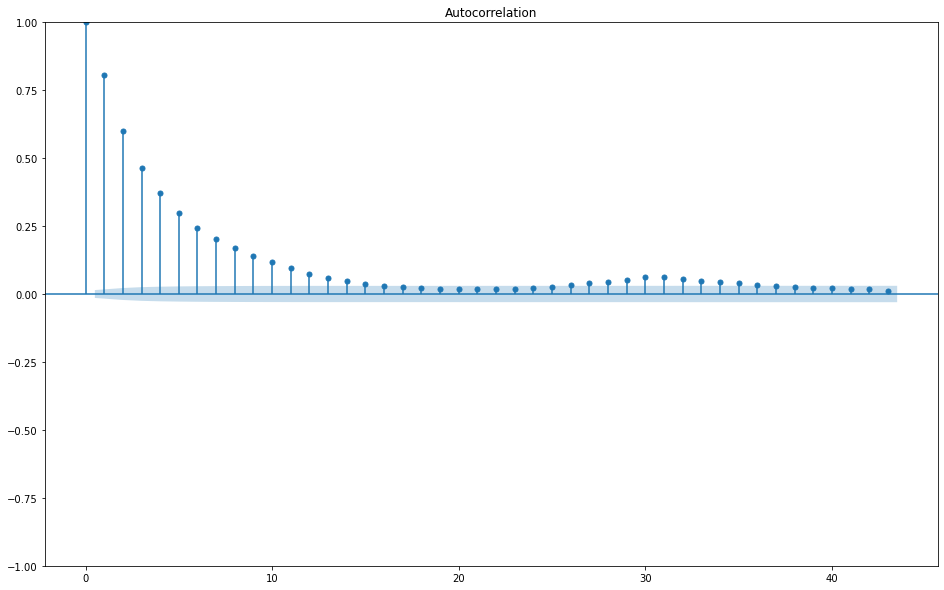

In [8]:
#plot the auto corelation of the time series y to get range of your 'q'
plot_acf(remainder);

plt.show()

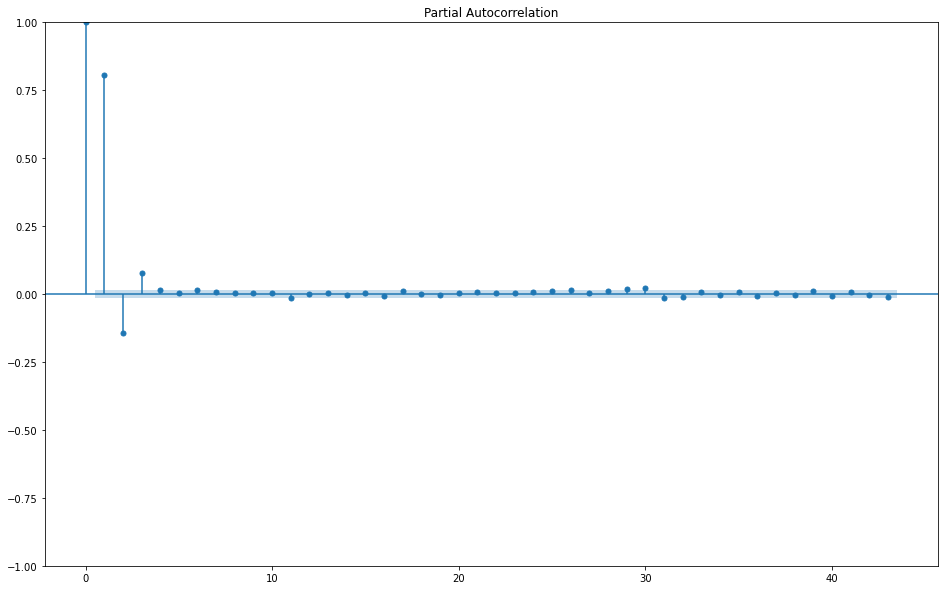

In [9]:
#plot the auto corelation of the time series y to get range of your 'p'
plot_pacf(remainder);

plt.show()

Find the best parameters for your ARIMA model based on the tuning using auto arima

In [10]:
#based on the plot q= 0:34, p=0:5, max d=1:2
auto_arima_model = auto_arima(temp_train['temp_c'], start_p=0, start_q=0, max_p=5, max_q=33, max_d=2)

In [11]:
auto_arima_model

In [12]:
##fit the ARIMA Model based on the auto arima tuning
model = ARIMA(temp_train['temp_c'], order=(3,1,1)).fit()


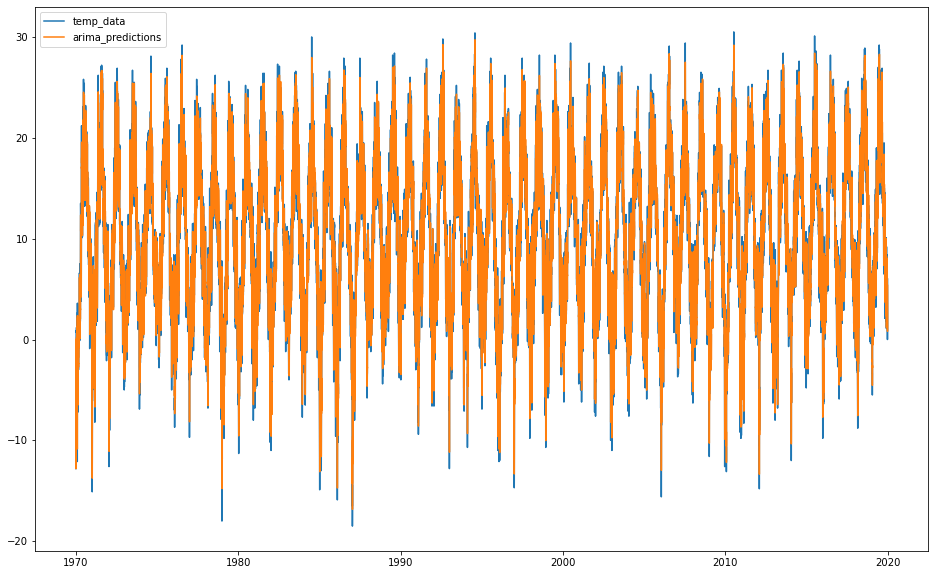

In [13]:
##plot to see if the the prediction based on just the time series is good

plt.plot(temp_train['temp_c'], label='temp_data')
plt.plot(model.predict(), label='arima_predictions')  # this is called in-sample predictions, predictions on test data
plt.legend()

plt.show()

Adding exogenal variable to the model to increase accuracy
In this case dummy month


In [14]:
seasonal_dummies = pd.get_dummies(temp_train.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(temp_train.index)

temp_train = temp_train.join(seasonal_dummies)  ##join seasonal dummy to temp_train

In [15]:
seasonal_dummies.head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,
1970-01-01,0,0,0,0,0,0,0,0,0,0,0
1970-01-02,0,0,0,0,0,0,0,0,0,0,0
1970-01-03,0,0,0,0,0,0,0,0,0,0,0
1970-01-04,0,0,0,0,0,0,0,0,0,0,0
1970-01-05,0,0,0,0,0,0,0,0,0,0,0


In [16]:
##Run ARIMA model by including seasonal variable
##we can also include the exog variable from the temp dataframe, but it must
##be in a data frame form temp_train[[]]
model_season = ARIMA(temp_train['temp_c'], order=(3,1,1), exog=seasonal_dummies).fit()

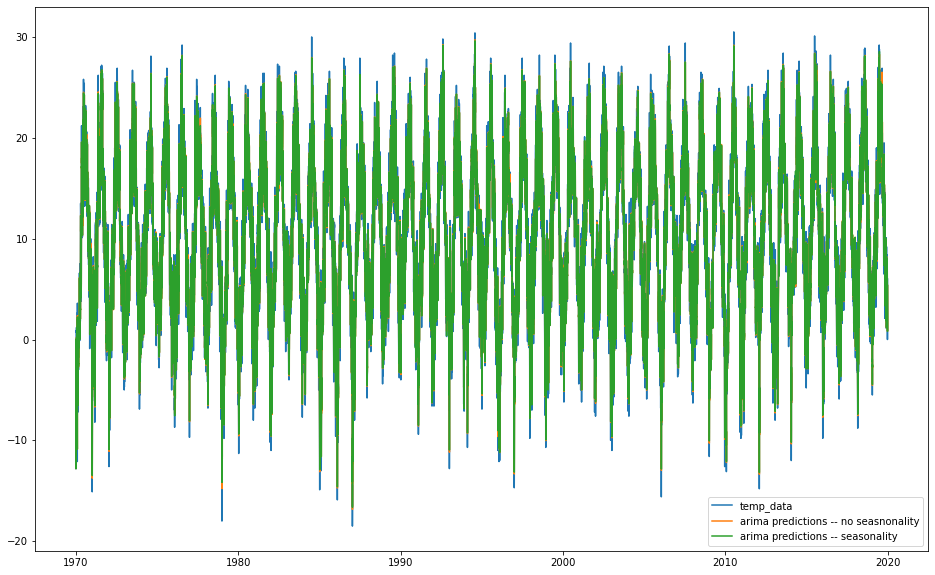

In [17]:
###plot all models and compare
plt.plot(temp_train['temp_c'], label='temp_data')
plt.plot(model.predict(), label='arima predictions -- no seasnonality')
plt.plot(model_season.predict(), label='arima predictions -- seasonality')
plt.legend()

plt.show()

In [18]:
##evaluate the two models: prediction with seasonality and no seasonality
rmse_no_seasonality = np.sqrt(mean_squared_error(temp_train['temp_c'], model.predict()))

rmse_seasonality = np.sqrt(mean_squared_error(temp_train['temp_c'], model_season.predict()))


In [19]:
rmse_no_seasonality, rmse_seasonality

(2.2742079628256806, 2.2704626854590075)

compare model with new data


In [20]:
###predict one step
model.forecast()   ###without exoge variable

2020-01-01    5.671604
Freq: D, dtype: float64

In [21]:
model_season.forecast(exog=seasonal_dummies.iloc[0]) ##with exo vari

2020-01-01    6.229822
Freq: D, dtype: float64

Predict multiple step

In [23]:
##import test data
temp_test=pd.read_csv('temp_test.csv', parse_dates=True, index_col=0)


In [24]:
temp_test.head()

,temp_c
date,
2020-01-01,2.7
2020-01-02,0.9
2020-01-03,4.6
2020-01-04,4.2
2020-01-05,1.8


In [25]:
##to predict for seasonal we need to creata a new dummy for all the test data

seasonal_dummies_test = pd.get_dummies(temp_test.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(temp_test.index)

In [26]:
seasonal_dummies_test.head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,0,0,0,0,0,0,0,0,0
2020-01-03,0,0,0,0,0,0,0,0,0,0,0
2020-01-04,0,0,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,0,0,0,0,0


In [27]:
##predict for timeseries and add to test df
temp_test['predictions']= model.predict(start='2020-01-01', end='2020-12-31').values

##predict for seasonality and add test df
temp_test['predictions_season']=model_season.predict(start='2020-01-01', end='2020-12-31', exog=seasonal_dummies_test).values

In [28]:
temp_test.head()

,temp_c,predictions,predictions_season
date,,,
2020-01-01,2.7,5.671604,6.229822
2020-01-02,0.9,5.278009,5.859695
2020-01-03,4.6,5.084812,5.694245
2020-01-04,4.2,4.987834,5.609994
2020-01-05,1.8,4.926508,5.550333


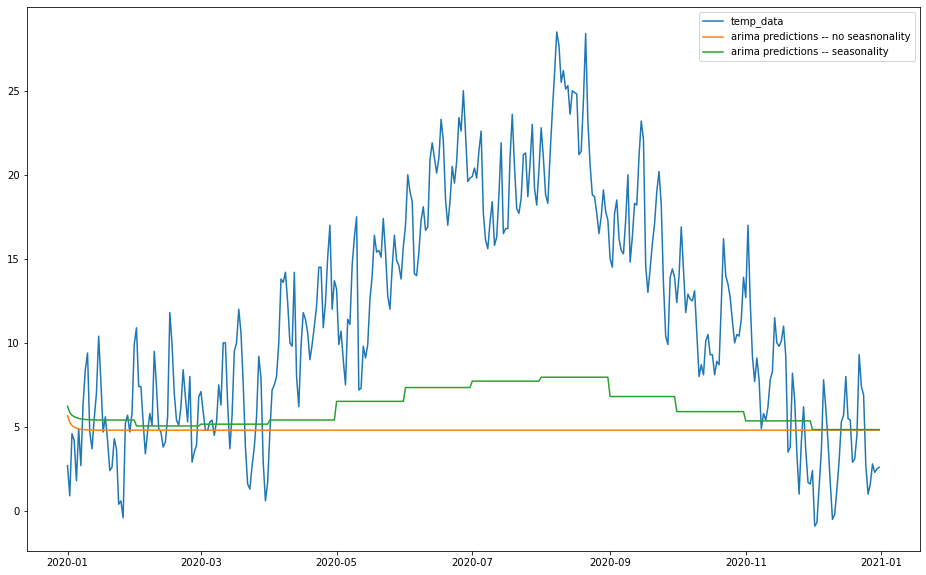

In [29]:
##plot the predictions
plt.plot(temp_test['temp_c'], label='temp_data')
plt.plot(temp_test['predictions'], label='arima predictions -- no seasnonality')
plt.plot(temp_test['predictions_season'], label='arima predictions -- seasonality')
plt.legend()

plt.show()



In [31]:
rmse_no_seasonality_test = np.sqrt(mean_squared_error(temp_test['temp_c'], temp_test['predictions']))

rmse_seasonality_test = np.sqrt(mean_squared_error(temp_test['temp_c'], temp_test['predictions_season']))

rmse_no_seasonality_test, rmse_seasonality_test

(9.689582780380887, 8.115452869889975)